In [2]:
!nvidia-smi

Sun Apr 30 05:30:45 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         On | 00000000:65:00.0 Off |                  N/A |
|  0%   47C    P8               47W / 390W|    234MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# (1) Import the necessary libraries

In [1]:
import glob
import pandas as pd
import tensorflow as tf
import numpy as np
import re
import time
import os
import tensorflow_hub as hub

2023-04-30 07:40:32.869523: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-30 07:40:32.905903: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# (2) Download the datasets

### You can download the datasets from https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset

In [8]:
!ls datasets/flickr30k_images

flickr30k_images  results.csv


# (3) Prepare the datasets

In [2]:
captioning_ds = pd.read_csv("datasets/flickr30k_images/results.csv", delimiter="|")

In [3]:
captioning_ds.head(10)

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .
5,10002456.jpg,0,Several men in hard hats are operating a gian...
6,10002456.jpg,1,Workers look down from up above on a piece of...
7,10002456.jpg,2,Two men working on a machine wearing hard hats .
8,10002456.jpg,3,Four men on top of a tall structure .
9,10002456.jpg,4,Three men on a large rig .


Use regex to remove some symbols and punctuation

In [4]:
def func(row):
    comment = str(row[2]).lower()
    comment = ' ' . join(re.findall(r"[a-z]+", comment))
    comment = re.sub(r"\s", " ", comment) # replace any multiple spaces
    return {"image_name": row[0], "comment": comment}

In [5]:
captionaing_cleaned = pd.DataFrame(dict(captioning_ds.apply(func, axis=1))).transpose()

In [6]:
captionaing_cleaned.head(3)

,image_name,comment
0,1000092795.jpg,two young guys with shaggy hair look at their ...
1,1000092795.jpg,two young white males are outside near many bu...
2,1000092795.jpg,two men in green shirts are standing in a yard


Create multigrams for all the comments

In [7]:
start_time = time.perf_counter()
print("Start processing ...")
complete_sets = []
for index, row in captionaing_cleaned.iterrows():
    comment_split = str("sevendi " + row.comment + " poluan") . split()
    for ind in range(1, len(comment_split)):
        complete_sets.append({
            "image_name": os.path.join("datasets/flickr30k_images/flickr30k_images", row.image_name), 
            "comment": ' ' . join(comment_split[:ind]),
            "target": comment_split[ind]
        })
end_time = time.perf_counter()
print(f"Processing time: {end_time - start_time} seconds")

Start processing ...
Processing time: 18.59415355231613 seconds


In [8]:
complete_sets_pd = pd.DataFrame(complete_sets)

So for each image we need to create an n-grams that would probably be the next prediction words to the model

In [9]:
complete_sets_pd.head(10)

,image_name,comment,target
0,datasets/flickr30k_images/flickr30k_images/100...,sevendi,two
1,datasets/flickr30k_images/flickr30k_images/100...,sevendi two,young
2,datasets/flickr30k_images/flickr30k_images/100...,sevendi two young,guys
3,datasets/flickr30k_images/flickr30k_images/100...,sevendi two young guys,with
4,datasets/flickr30k_images/flickr30k_images/100...,sevendi two young guys with,shaggy
5,datasets/flickr30k_images/flickr30k_images/100...,sevendi two young guys with shaggy,hair
6,datasets/flickr30k_images/flickr30k_images/100...,sevendi two young guys with shaggy hair,look
7,datasets/flickr30k_images/flickr30k_images/100...,sevendi two young guys with shaggy hair look,at
8,datasets/flickr30k_images/flickr30k_images/100...,sevendi two young guys with shaggy hair look at,their
9,datasets/flickr30k_images/flickr30k_images/100...,sevendi two young guys with shaggy hair look a...,hands


# (4) Create text tokenizer

I want to know the total vocabulary and sequence length that we have in our training sets

In [10]:
TOTAL_VOCAB = len(np.unique(' ' . join(list(captionaing_cleaned.comment)).split()))
TOTAL_VOCAB

18079

In [11]:
SEQ_LENGTH = max([len(x) for x in complete_sets_pd.comment])
SEQ_LENGTH

406

In [12]:
vectorize = tf.keras.layers.TextVectorization(max_tokens=TOTAL_VOCAB, output_mode="int", output_sequence_length=SEQ_LENGTH)

2023-04-30 07:41:03.876581: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22009 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


In [13]:
start_time = time.perf_counter()
print("Start processing ...")

vectorize.adapt(captionaing_cleaned.comment, batch_size=32)

end_time = time.perf_counter()
print(f"Processing time: {end_time - start_time} seconds")

Start processing ...
Processing time: 12.095918516162783 seconds


# (4) Create a data loader for our image

In [14]:
IMG_SIZE = [244, 244]

In [15]:
def data_loader(row):
    image_path = row[0]
    comment = row[1]
    target = row[2]
    
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image) 
    image = tf.image.resize(image, IMG_SIZE)
    
    tokenized_comment = vectorize(comment)
    tokenized_target = tf.reduce_sum(vectorize(target)) # just to get the lable so i just sum all the array up because it's the only one in the array
    
    return (image, tokenized_comment), tokenized_target

In [16]:
train_ds = tf.data.Dataset.from_tensor_slices(complete_sets_pd)

In [17]:
BATCH_SIZE = 32

In [18]:
train = train_ds.map(data_loader).cache().prefetch(tf.data.AUTOTUNE).shuffle(buffer_size=1000).batch(BATCH_SIZE)

# (5) Build the models

In [19]:
segmentation = tf.keras.Sequential([ 
    tf.keras.layers.Rescaling(1./255.),
    tf.keras.layers.RandomHeight(.2),
    tf.keras.layers.RandomWidth(.2),
    tf.keras.layers.RandomZoom(.2),
    tf.keras.layers.RandomFlip("horizontal")
])

In [56]:
def create_model():
    # word embedding
    embedding = tf.keras.layers.Embedding(input_dim=TOTAL_VOCAB, output_dim=1024, input_length=SEQ_LENGTH)

    # pretrained resnet
    resnet152 = tf.keras.applications.ResNet152(include_top=False, input_shape=IMG_SIZE + [3])
    resnet152.trainable = False

    inputs_img = tf.keras.layers.Input(shape=IMG_SIZE + [3])
    inputs_comment = tf.keras.layers.Input(shape=(SEQ_LENGTH))

    x_img = segmentation(inputs_img)
    x_img = resnet152(x_img, training=False)
    x_img = tf.keras.layers.Dense(1024)(x_img)
    x_img = tf.keras.layers.GlobalAveragePooling2D()(x_img)

    x_comment = embedding(inputs_comment)
    x_comment = tf.keras.layers.LSTM(1024)(x_comment)
    x_comment = tf.keras.layers.Dense(1024)(x_comment)

    concat = tf.keras.layers.Concatenate()([x_img, x_comment])
    concat = tf.keras.layers.Dense(1024, activation="relu")(concat)
    outputs = tf.keras.layers.Dense(TOTAL_VOCAB, activation="softmax")(concat)
    model = tf.keras.Model((inputs_img, inputs_comment), outputs)
    
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                  metrics=["accuracy"])
    
    model.summary()
    
    return model

In [57]:
model = create_model()

2023-04-30 07:51:00.407725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-30 07:51:00.408854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-30 07:51:00.410117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 244, 244, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, None, None,   0           ['input_17[0][0]']               
                                None)                                                             
                                                                                                  
 input_18 (InputLayer)          [(None, 406)]        0           []                               
                                                                                            

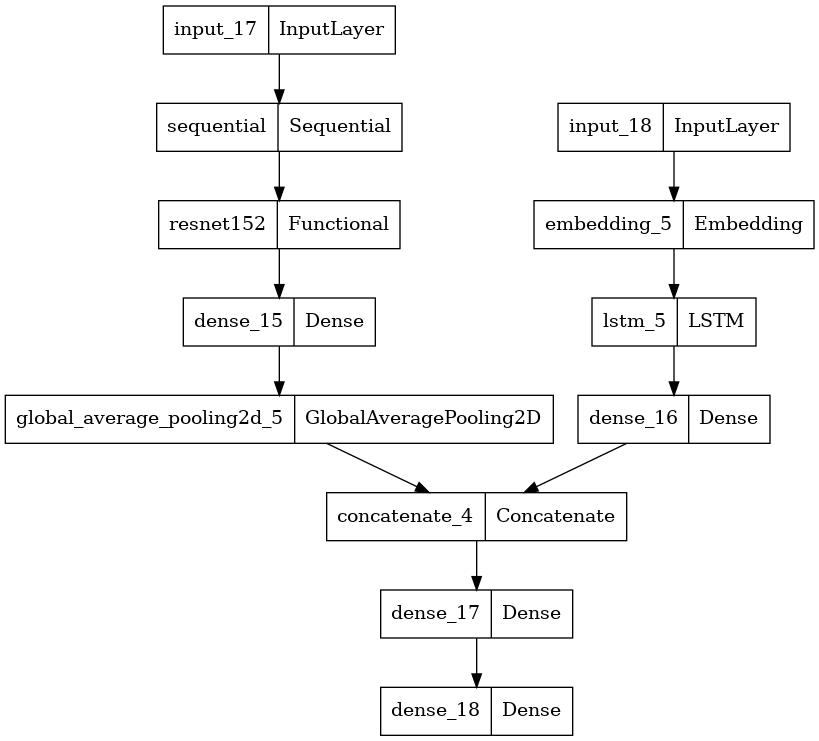

In [58]:
tf.keras.utils.plot_model(model)

# (6) Prepare for training

In [59]:
class ModelCheckpointCustom(tf.keras.callbacks.Callback):
    
    def __init__(self, model_path, save_best_only=False):
        super(ModelCheckpointCustom, self).__init__()
         
        self.model_path = model_path
        self.save_best_only = save_best_only
        self.best_val_loss = float('inf') 

    def on_epoch_end(self, epoch, logs=None):
        
        print('\rlogs: ', logs, '\r')
        
        current_val_loss = 0 if logs['val_loss'] is None else logs['val_loss']
        
        print('\rcurrent_val_loss: ', current_val_loss, '\r')
        print('\rsave_best_only: ', self.save_best_only, '\r')
        print('\rbest_val_loss: ', self.best_val_loss, '\r')
        print('\rcurrent_val_loss < best_val_loss: ', current_val_loss < self.best_val_loss, '\r') 
        
        if self.save_best_only and current_val_loss < self.best_val_loss:
            print('\rSaving weights at (save_best_only=True): ', self.model_path, '\r')
            self.best_val_loss = current_val_loss 
            self.model.save_weights(self.model_path)
            print("\rModel has been saved!")
        else:
            print('\rSaving weights at (save_best_only=False): ', self.model_path, '\r')
            self.model.save_weights(self.model_path) 
            print("\rModel has been saved!")

save_callbacks = ModelCheckpointCustom(model_path='checkpoint/save-model/', save_best_only=True)

In [60]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=7, start_from_epoch=0)

# (7) Train the models

In [ ]:
history = model.fit(train, epochs=200, callbacks=[save_callbacks, early_stop])

Epoch 1/200


2023-04-30 07:51:02.184301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-30 07:51:02.185884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-30 07:51:02.186999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  161/66068 [..............................] - ETA: 6:53:41 - loss: 6.5341 - accuracy: 0.1238